# Renco - OBV strategy

# how the strategy works:

We assume that two renco bars with big obv slope leads to further growth of the market

Renko is a special type of data representation that is independent of time. 
Each Renko brick is formed depending on the increase or fall of the market by a certain amount

For simplicity, the transaction fee is assumed to be 0

We use time between 09:35 and 16:00 as regular trading hours

We use 5 minute trading bars

<ol>
 <li>Average True Range (ATR) - we need this for calculating the stop loss</li>
 <li>Cumulative Annual Growth Rate (CAGR) for comparison of the strategy at different stock</li>
 <li>Slope to determine the market trend</li>
</ol>

Additional materials used: 
https://www.udemy.com/course/algorithmic-trading-quantitative-analysis-using-python/
Renco https://www.youtube.com/watch?v=8lA9vk8SRDE

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from stocktrends import Renko
import statsmodels.api as sm
# alpha_vantage is library for getting some more stock
from alpha_vantage.timeseries import TimeSeries
import copy



from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)


def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [2]:
# Download historical data for DJI constituent stocks

tickers = ["AAPL","MSFT", "SPY"]
# you can get your own API key here: https://www.alphavantage.co/
ts = TimeSeries(key='MRA63QBLDA8JNZJW', output_format='pandas')

ohlc_intraday = {} # directory with ohlc value for each stock   

for ticker in tickers:
    data = ts.get_intraday(symbol=ticker,interval='5min', outputsize='full')[0]

    data.columns = ["Open","High","Low","Close","Volume"]
#     because we get data reversing order from alpha_vantage
    data = data.iloc[::-1]
    data = data.between_time('09:35', '16:00') #remove data outside regular trading hours
    ohlc_intraday[ticker] = data

In [3]:
euros = pd.read_csv('eurostoxx_data.csv', index_col='DateTime')
euros.index = pd.to_datetime(euros.index)
euros = euros.between_time('09:35', '16:00')

# resample to 5 minutes dataframe
conversion = {'Open' : 'first', 'High' : 'max', 'Low' : 'min', 'Close' : 'last', 'Volume' : 'sum'}
euros = euros.resample('5min').agg(conversion)
# because resample automatically adds days off filled with NaN
euros.dropna(inplace=True)
# because for renco we need same column names for each time series
euros.index.names = ['date']

ohlc_intraday["EUROS"] = euros

tickers = ohlc_intraday.keys()

In [4]:
#Merging renko df with original ohlc df
# Here we use Renco library for generating bricks
ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
    df[ticker]["Date"] = df[ticker].index
#     Because Renco is time independant, we have to use 'merge'
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["obv"]= OBV(ohlc_renko[ticker])
    ohlc_renko[ticker]["obv_slope"]= slope(ohlc_renko[ticker]["obv"],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

merging for  AAPL


<ipython-input-1-c9de2b0c41a2>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
<ipython-input-1-c9de2b0c41a2>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
<ipython-input-1-c9de2b0c41a2>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['direction'][0] = 0


merging for  MSFT
merging for  SPY
merging for  EUROS


In [5]:
#Identifying signals and calculating daily return
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
#             if we have 2 and more Renco up bricks, and slope more than 30 degree we produce "Buy" signal
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30:
                tickers_signal[ticker] = "Buy"
#             if we have 2 and more Renco down bricks, and slope less than -30 degree we assume down trend and  produce "Sell" signal
            elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30:
                tickers_signal[ticker] = "Sell"
#         Stop loss generation 
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Close"][i]/ohlc_renko[ticker]["Close"][i-1])-1)
            if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30:
                tickers_signal[ticker] = "Sell"
            elif ohlc_renko[ticker]["bar_num"][i]<2:
                tickers_signal[ticker] = ""
                
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Close"][i-1]/ohlc_renko[ticker]["Close"][i])-1)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]>-2:
                tickers_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating daily returns for  AAPL
calculating daily returns for  MSFT
calculating daily returns for  SPY
calculating daily returns for  EUROS


,Return,Sharpe Ratio,Max Drawdown
AAPL,0.367141,1.250033,0.052968
MSFT,-0.365298,-1.744703,0.084419
SPY,0.924096,4.403867,0.027582
EUROS,0.037017,0.049415,0.284292


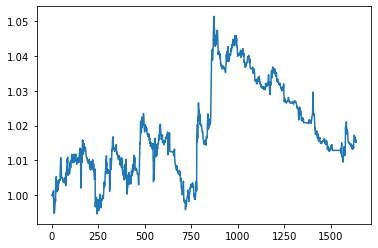

In [6]:
# calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
#     Cause of different time range we calculate "EUROS" separatly
    if ticker == 'EUROS': continue
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)

# vizualization of strategy return
(1+strategy_df["ret"]).cumprod().plot()

#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers :
      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

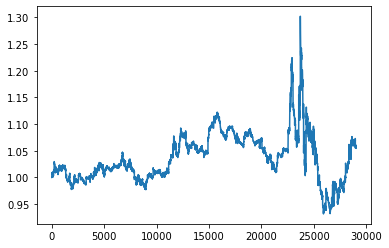

In [7]:
(1+ohlc_renko['EUROS']["ret"]).cumprod().plot()

# Things to improve

<ol>
 <li>Overnight positions is allowed, which introduces a significant risk to the strategy</li>
 <li>Addition test on different time intervals required</li>
 <li>Addition test on different stocks required</li>
 <li>Need add a fee to each transaction</li>
 <li>Different slope degree or renco bricks number can increase sharpe</li>
</ol>
Аn interesting strategy that uses a time-independent indicator. You can play with the parameters with which slope and the number of bricks will provide better signals. Also more volatile stocks generate more signals.